In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import os
import math, random

myCsv="F:/Data_BachelorHES/5.Dataset_preparation/2.Folds/FoldData.csv"
df = pd.read_csv(myCsv)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [21]:
myTrain=df.loc[(df['Fold']==0) & (df['Type']=='Train')].copy()
labelCount=myTrain['Label'].value_counts()
print(labelCount)
del myTrain, labelCount

Label
10_T02 M06 (VHM 309-12)      360
2_T02 M06 (VHM 309-12)       225
11_T03 M06 (VHM 309-6)       190
4_T08 M06 (MECHE3.7 MD)      179
12_T06 M06 (VHM 309-3)       173
13_T23 M06 (CHANF8)          140
5_T09 M06 (MECHE4.6 MD)       53
7_T10 M06 (MECHE5.5 MD)       46
9_T24 M06 (FRSURF50X5)        37
3_T14 M06 (MECHE5.3)          36
6_T19 M06 (MECHE MD D4.8)     14
8_T05 M06 (MECHE MD D5.8)     13
1_T07 M06 (MECHE MD D4.2)      4
14_T22 M06 (CHANF3)            4
Name: count, dtype: int64


## Resampling and drop of minorities classes

Prendre 1 sur 3 pour "10_T02" et "2_T02" => 195 datapoints
Augmenter par 4 5_T09, 7_T10 => (212, 196)
Augmenter par 5 9_T24, 3_T14 => (185, 190)
Augmenter par 13 6_T19 et 8_T05 => (182, 169)
Drop 1_T07 et 14_T22 


## Dropping the minority classes

In [22]:
#Drop the rows which still have labels 14_T22 M06 (CHANF3) and 1_T07 M06 (MECHE MD D4.2)
myGlobalDs=df.drop(df[(df['Label']=='1_T07 M06 (MECHE MD D4.2)') | (df['Label']=='14_T22 M06 (CHANF3)')].index)

## Merging the majority classes "10_T02" and "2_T02"

In [23]:
#Replace label 2_T02 M06 (VHM 309-12) by 10_T02 M06 (VHM 309-12)
myGlobalDs['Label']=myGlobalDs['Label'].replace('2_T02 M06 (VHM 309-12)', '10_T02 M06 (VHM 309-12)')

# Downsampling and Data augmentation

### Data augmentation functions

In [24]:

class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def load_file(snd_file, acc_x_file, acc_y_file, acc_z_file):
        """Load a group of individual sensors'files and return a NumPy array with 4 columns (one for each sensors)."""
    
        def read_csv_to_numpy(filepath):
            """Read CSV file and convert it to a NumPy array of int16."""
            with open(filepath, 'r', newline='', encoding="utf-8") as csvfile:
                reader = csv.reader(csvfile, delimiter=',')
                data = [list(map(np.int16, row)) for row in reader]  # Convertir chaque valeur en int
            return np.array(data, dtype=np.int16).flatten()  # Aplatir si nécessaire
        
        # Charger chaque signal
        sound = read_csv_to_numpy(snd_file)
        accel_x = read_csv_to_numpy(acc_x_file)
        accel_y = read_csv_to_numpy(acc_y_file)
        accel_z = read_csv_to_numpy(acc_z_file)
        
        # Empiler correctement en un tableau `(4, 250062)`
        return np.stack([sound, accel_x, accel_y, accel_z], axis=-1)
    @staticmethod
    def save_file(my_npy, dest_dir, file_name):
        """Save a file."""
        np.save(os.path.join(dest_dir, file_name), my_npy)

    
    def add_gaussian_noise(my_sig, std=0.02):
        """Add a gaussian noise."""
        my_sig_float=my_sig.astype(np.float32)
        noise = np.random.normal(0, std * np.std(np.abs(my_sig_float), axis=0), my_sig.shape)
        noisy_sig=np.clip(my_sig_float+noise, -32768,32767)        
        return noisy_sig.astype(np.int16)
    
    def time_shift(my_sig, shift_lim=0.5):
        """Shifts the data in time (reintroduce ending values at the beginning."""
        _, s_len = my_sig.shape
        shift_amt = int(np.random.random() * shift_lim * s_len)
        return np.roll(my_sig, shift_amt, axis=0)
    
    @staticmethod
    def augment_fft(data, factor=1.2):
        """Augmente ou diminue certaines fréquences du signal"""
        
        fft_data = np.fft.fft(data, axis=0)
        fft_data = fft_data * factor  # Modification du spectre
        new_data=np.real(np.fft.ifft(fft_data, axis=0))  # Retourne le signal temporel
        new_data = np.clip(new_data, -32768, 32767)
        return new_data.astype(np.int16)



### Downsampling and storing 1 .npy file for the 4 sensors 

In [27]:
from tqdm import tqdm
import os
import numpy as np 
import pandas as pd
import csv


def csv_to_npy(my_train, i, src_dir, dest_dir, dest_dir_name):
    """Converts the data from the .csv files to .npy files and save them in the destination directory.
    returns : a list of the new rows (with only one filename) to add to the dataframe.
    """
    
    newNpyRows=[]
    for idx, row in tqdm(my_train.iterrows(), desc="Processing files", total=my_train.shape[0]):
    
        observation_load=DataUtils.load_file(os.path.join(src_dir, row['Snd']), os.path.join(src_dir, row['AccX']), os.path.join(src_dir, row['AccY']), os.path.join(src_dir, row['AccZ']))
        fileName=str(row['Snd'].split('_')[0]+'_label_'+row['Snd'].split('_')[-1]).split('.csv')[0]+'.npy'
        DataUtils.save_file(observation_load, dest_dir, fileName)
        newNpyRows.append([row['nb'], row['Label'], row['condLabel'], fileName, os.path.join(dest_dir_name, fileName)])
    return newNpyRows

def process_fold(my_df, fold_i, data_type, src_dir, dst_dir, labels_to_decrease=None, decrease_rate=3):
    """Process a fold of the dataset.
        Downsamples the majority class by the decreaseRate rate if a training set and save the files in subdirectories from the mainDir directory path. data from sensors initially stored within .csv files for each sensor are now stored together in .npy files.
        df: is the main DataFrame containing the metadata, that is name and location of files.  
        fold: the fold number to process.
        dataType: the type of data to process (Train or Test). Downsampling will be applied only if 'Train' is passed
        mainDir: the main directory path where the files are located.
        labelsToDecrease: the list of labels to downsample.
        decreaseRate: the rate of downsampling.
        
        
        returns: a dataframe with the columns : Fold - fold number, type train or test,  nb - number of the sample, label, filepath - relative path of each file, filename - the new .npy filename
            
    """
    if labels_to_decrease is None:
        labels_to_decrease = ["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"]
    data = my_df[(my_df['Fold'] == fold_i) & (my_df['Type'] == data_type)].copy()
    if data.empty:
        return pd.DataFrame(columns=["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"])

    # Gestion des labels à exclure ou downsampler uniquement pour Train
    if data_type == "Train":
        downsampled_data = data[data['Label'].isin(labels_to_decrease)].iloc[::decrease_rate].copy()
        data = data[~data['Label'].isin(labels_to_decrease)] 
        data = pd.concat([data, downsampled_data], ignore_index=True)

    # Tri des observations
    data.sort_values(by=['nb'], inplace=True)

    # Définition des répertoires
    srcDir = os.path.join(src_dir, data['Dir'].iloc[0])
    destDirName = f"{data_type.lower()}_Npy_fold_{fold_i}"
    destDir = os.path.join(dst_dir, destDirName)
    os.makedirs(destDir, exist_ok=True)

    # Conversion et sauvegarde
    processed_data = csv_to_npy(data, fold_i, srcDir, destDir, destDirName)

    # Création du DataFrame avec les nouvelles métadonnées
    return pd.DataFrame(processed_data, columns=["nb", "Label", "condLabel", "FileName", "FilePath"]).assign(Fold=fold_i, Type=data_type)[["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"]]



In [29]:
srcDir="F:/Data_BachelorHES/5.Dataset_preparation/2.Folds" 
destDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
myDownSampledDs=pd.DataFrame(columns=["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"])
for i in range(0, 5):
    myDownSampledDs = pd.concat([myDownSampledDs, process_fold(myGlobalDs, i, "Train", srcDir, destDir, labels_to_decrease=["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"], decrease_rate=3)], ignore_index=True)

    
    myDownSampledDs= pd.concat([myDownSampledDs, process_fold(myGlobalDs, i, "Test", srcDir, destDir, labels_to_decrease=["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"], decrease_rate=3)], ignore_index=True)
    

Processing files: 100%|██████████| 367/367 [06:06<00:00,  1.00it/s]


In [32]:
myDownSampledDs.to_csv(os.path.join(destDir,f"GlobalFoldsFiles_Train_Test_orignal_Npy.csv"))

# Data augmentation

Augmenter par 4 5_T09, 7_T10 => (212, 196)     5_T09 M06 (MECHE4.6 MD)   7_T10 M06 (MECHE5.5 MD)
Augmenter par 5 9_T24, 3_T14 => (185, 190)     9_T24 M06 (FRSURF50X5)    3_T14 M06 (MECHE5.3)
Augmenter par 13 6_T19 et 8_T05 => (182, 169)  6_T19 M06 (MECHE MD D4.8) 8_T05 M06 (MECHE MD D5.8)

In [31]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def newSig(obsSig):
    dice=np.random.rand()
    if 0<dice<=0.33:
        augmentedSig=DataUtils.add_gaussian_noise(obsSig)
    elif 0.33<dice<=0.66:
        augmentedSig=DataUtils.time_shift(obsSig)
    else:
        augmentedSig=DataUtils.augment_fft(obsSig)
    return augmentedSig

def prepareDFandSaveAugmentedData(myDir, numToGenerate, files_to_augment, label, condLabel):
        myRows=[]
        for i in range(numToGenerate):
            fileToAugment=files_to_augment[i % len(files_to_augment)]
            newFilePath=fileToAugment.split('.npy')[0]+"_aug"+str(i)+".npy"
            myRows.append([label, condLabel, newFilePath.split("\\")[-1], newFilePath])
            
            observationLoad=np.load(os.path.join(myDir,fileToAugment))
            augmentedSig=newSig(observationLoad)
            DataUtils.save_file(augmentedSig, myDir, newFilePath)
        return myRows



def augmentTrainingSet(myDir, myDataSetsFiles):
    if myDataSetsFiles.empty:
        return pd.DataFrame(columns=["nb", "Label", "condLabel", "FileName", "FilePath"])
    
    augmentedRows=[]
    labelCounts=myDataSetsFiles['Label'].value_counts()
    
    for label, count in tqdm(labelCounts.items(), desc="Progress", total=len(labelCounts)):
        condLabel=myDataSetsFiles[myDataSetsFiles['Label'] == label]['condLabel'].iloc[0]
        files_to_augment = myDataSetsFiles[myDataSetsFiles['Label'] == label]['FilePath'].values
        
        numToGenerate = 0
        if label in ["5_T09 M06 (MECHE4.6 MD)", "7_T10 M06 (MECHE5.5 MD)"]:
            numToGenerate=len(files_to_augment)*3 
        elif label in ["9_T24 M06 (FRSURF50X5)", "3_T14 M06 (MECHE5.3)"]:
            numToGenerate=len(files_to_augment)*4
        elif label in ["6_T19 M06 (MECHE MD D4.8)", "8_T05 M06 (MECHE MD D5.8)"]:
            numToGenerate=len(files_to_augment)*12
        else:
            continue #If label not in list, skip to next iteration
        
        augmentedRows.extend(prepareDFandSaveAugmentedData(myDir, numToGenerate, files_to_augment, label, condLabel))
    if not augmentedRows:
        return pd.DataFrame(columns=["nb", "Label", "condLabel", "FileName", "FilePath"])
    
    formattedAugRows = pd.DataFrame(augmentedRows, columns=["Label", "condLabel","FileName", "FilePath"])
    formattedAugRows.insert(0, "nb", np.nan)
    return formattedAugRows



In [33]:
#Applicaiton of the data augmentation on the training set

#"Root" Dir above the "npy" folds
myDir="F:/Data_BachelorHES/5.Dataset_preparation/3.TrainsetBalancing"
dataType="Train"
for fold in range(0, 5):
    myDataSetsFiles=myDownSampledDs[(myDownSampledDs['Fold'] == fold) & (myDownSampledDs['Type'] == dataType)].copy()
    myAugmentedFiles=augmentTrainingSet(myDir, myDataSetsFiles)
    myAugmentedFiles=myAugmentedFiles.assign(Fold=fold, Type=dataType)[["Fold", "Type", "nb", "Label", 'condLabel', "FilePath","FileName"]]
    
    myDownSampledDs=pd.concat([myDownSampledDs,myAugmentedFiles], ignore_index=True)


myDownSampledDs.to_csv(os.path.join(myDir,f"GlobalFoldsFiles_Train_Test_Augmented.csv"))

#Cleaning of the memory of notebook
del myDataSetsFiles, myAugmentedFiles, dataType

Progress: 100%|██████████| 11/11 [04:50<00:00, 26.37s/it]


## Encoding the labels

In [39]:
from sklearn.preprocessing import LabelEncoder

#Encode the Labels into IDs and save the mapping to main DataFrame 

#Add a columns LabelIDs to the myGlobalDs dataframe
le=LabelEncoder()
myDownSampledDs['LabelIDs']=le.fit_transform(myDownSampledDs['Label'])
mapping=dict(zip(le.classes_, range(len(le.classes_))))

print("Results of the encoding of the labels")
for item in mapping:
    n=30-len(item)
    spaces=" "*n
    print(item, spaces,": ", mapping[item])
del le, mapping, n, spaces, item

Results of the encoding of the labels
10_T02 M06 (VHM 309-12)         :  0
11_T03 M06 (VHM 309-6)          :  1
12_T06 M06 (VHM 309-3)          :  2
13_T23 M06 (CHANF8)             :  3
3_T14 M06 (MECHE5.3)            :  4
4_T08 M06 (MECHE3.7 MD)         :  5
5_T09 M06 (MECHE4.6 MD)         :  6
6_T19 M06 (MECHE MD D4.8)       :  7
7_T10 M06 (MECHE5.5 MD)         :  8
8_T05 M06 (MECHE MD D5.8)       :  9
9_T24 M06 (FRSURF50X5)          :  10


In [40]:
myDownSampledDs.to_csv(os.path.join(myDir,f"GlobalFoldsFiles_Train_Test_Augmented_Cleaned.csv"))

## Analysis of the results of Balancing

In [41]:
#Synthesis of the distribution of the labels in the folds
labelCounts= {}
for fold in range(0,5):
    #Count labels in Train set of a fold
    myDataSetsFiles=myDownSampledDs[(myDownSampledDs['Fold'] == fold) & (myDownSampledDs['Type'] == "Train")].copy() #Extract a subset of the train data for fold i
    labelCounts[f"Train_Fold_{fold}"]=myDataSetsFiles['Label'].value_counts() #Count the label in the subset
    
    #Count labels in Test set of a fold
    myDataSetsFiles=myDownSampledDs[(myDownSampledDs['Fold'] == fold) & (myDownSampledDs['Type'] == "Test")].copy()
    labelCounts[f"Test_Fold_{fold}"]=myDataSetsFiles['Label'].value_counts()

labFrame=pd.DataFrame(labelCounts)
del labelCounts, myDataSetsFiles

In [42]:
labFrame=labFrame.fillna(0)
labFrame=labFrame.div(labFrame.sum(axis=0), axis=1)*100

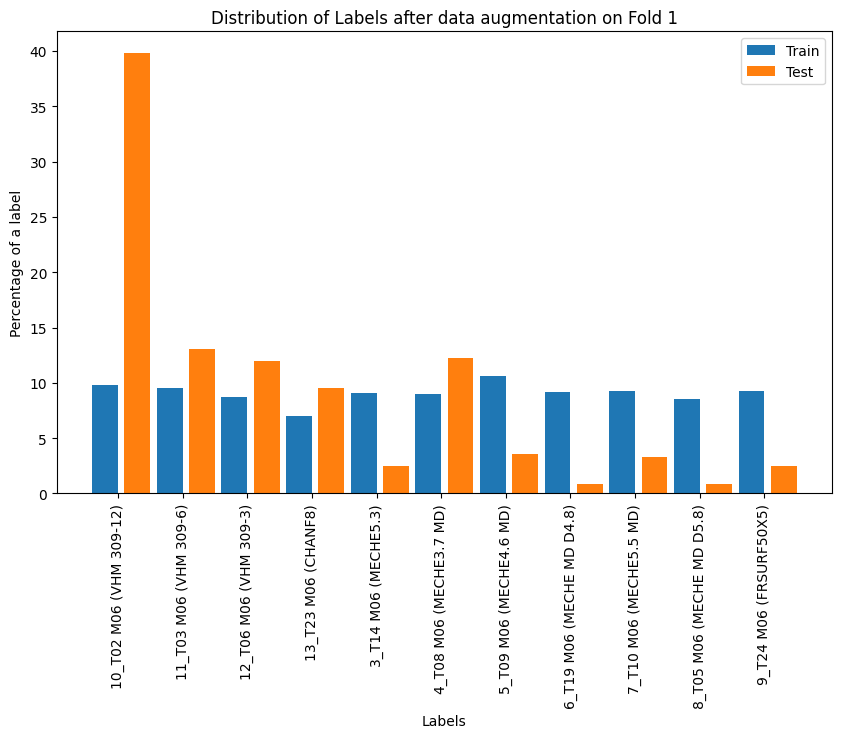

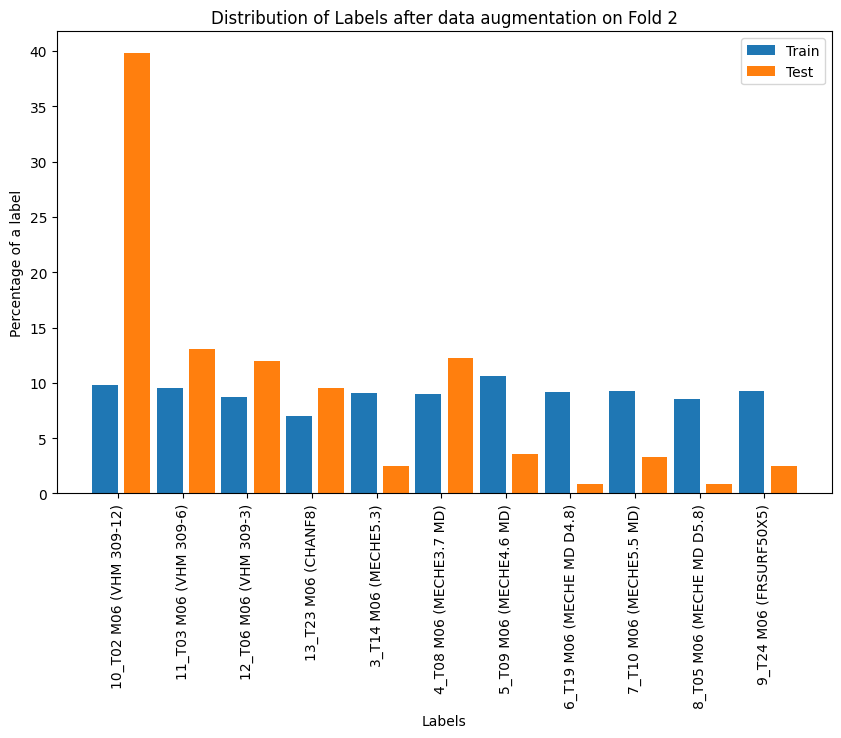

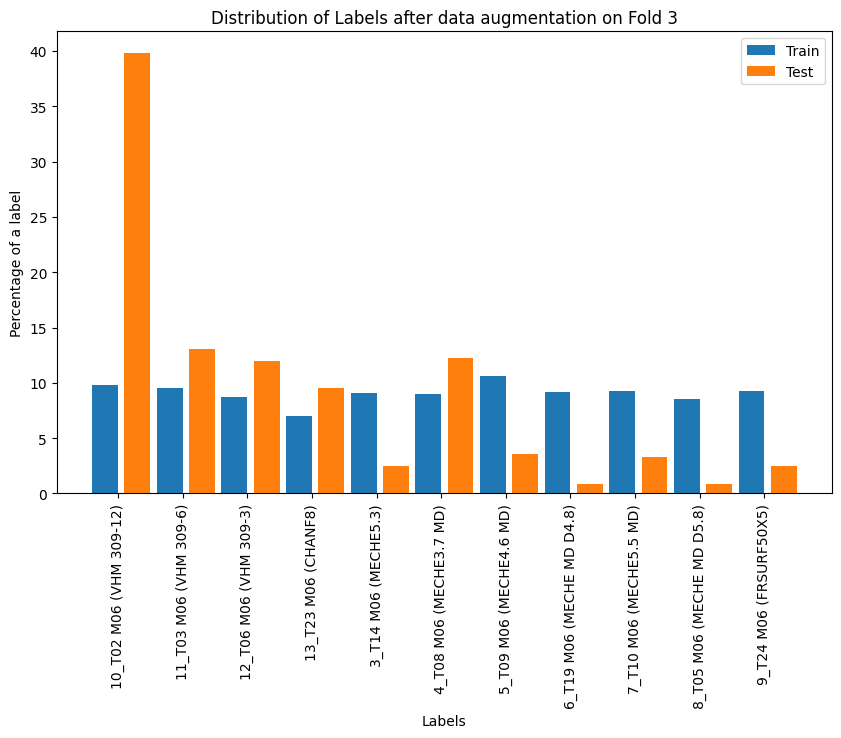

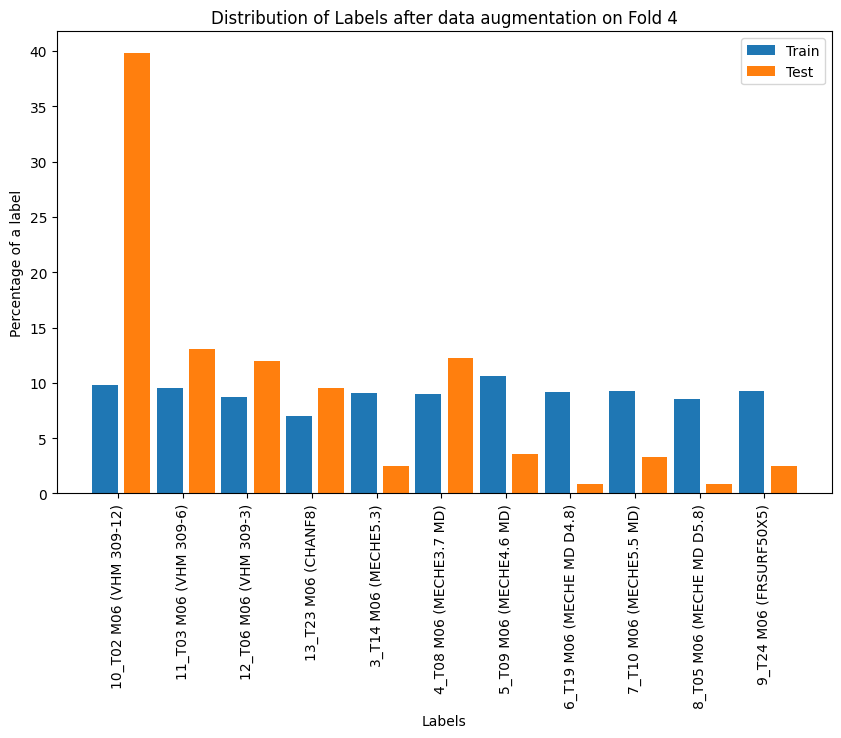

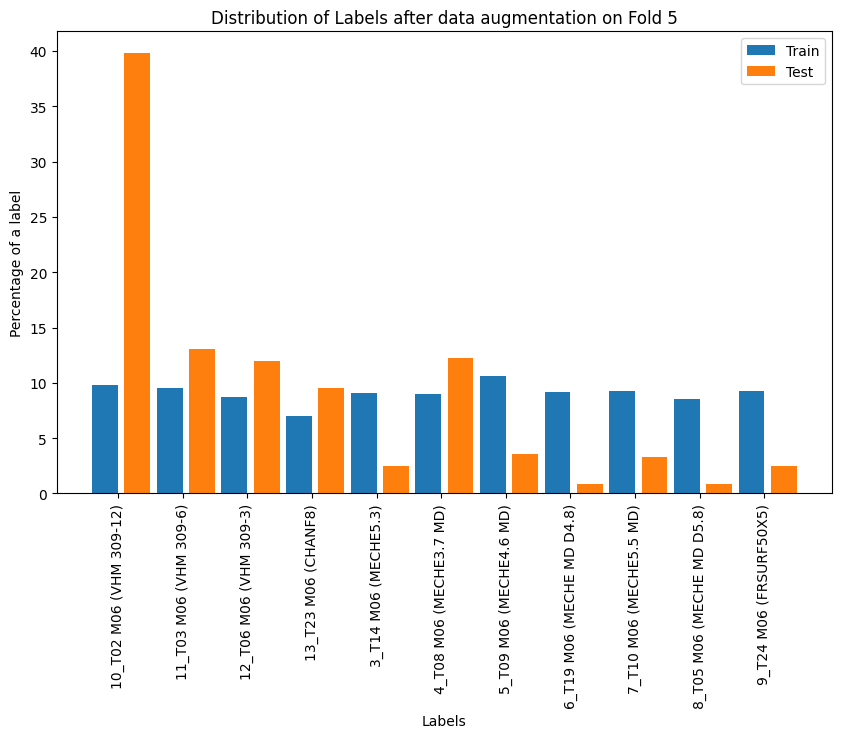

In [43]:

#Prepare a plot of distribution of data in each fold

from matplotlib import colormaps
import matplotlib as mpl

for i in range(0,5):

    X_axis = np.arange(len(labFrame)) # the label locations
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(X_axis - 0.2, labFrame[f"Train_Fold_{i}"], width=0.4, label = 'Train', ) 
    plt.bar(X_axis + 0.3 , labFrame[f"Test_Fold_{i}"], width=0.4, label = 'Test') 
    
    plt.xticks(X_axis, labFrame.index, rotation=90) 
    ax.set_title(f"Distribution of Labels after data augmentation on Fold {i+1}")
    ax.set_ylabel("Percentage of a label")
    ax.set_xlabel("Labels")
    ax.legend()

plt.show()


In [44]:
del X_axis, ax, colormaps, fig, fold, i, 